In [1]:
import numpy as np
from numpy.random import uniform, randn
import matplotlib.pyplot as plt
import math
from math import sin, cos, pi, sqrt
import random

In [2]:
# PARTICLE FILTER STEPS 
# 1: You have a distribution that describes your current belief
# 2: Generate samples from this distribution in the domain where things are evolving 
# 3: Weight the samples according to probability mass


# 4: Update the distribution ... to do this we update the individual samples by taking each sample 
#    and applying your integrator scheme (possibly with noise x_dot = f( x, u + noise))
# 5: generate new set of samples
# 6: Tranform old set of samples to new set ... take ONE measurement (DO NOT start sampling from measurement model)
# 7: Given the ONE measurement how likely are all of the different predictions 
# 8: Weight all these predicitons by liklihood under the measurement model that you have 

In [3]:
# Givens
variance = 0.02
sigma    = sqrt(variance)


T  = 6 # seconds
dt = 0.1
N  = int(T/dt)
n  = 3


s0  = [0, 0, np.pi/2]
u   = np.array([1, -1/2])



In [4]:
# functions for process noise and measurement noise

def create_normal_distribution(mean, std, N):
    '''
    Generates normal distribution
    Use to generate initial xt
    '''
    particles = np.empty((3, N))
    particles[0, :] = mean[0] + (randn(N) * std)
    particles[1, :] = mean[1] + (randn(N) * std)
    particles[2, :] = mean[2] + (randn(N) * std)
    return particles

def noise_distribution(mean, std):
    '''
    Generates normal distribution 
    '''
    noise = np.zeros(2)
    N = 1
    noise[0] = mean[0] + (randn(N) * std)
    noise[1] = mean[1] + (randn(N) * std)
    return noise


def weight_distribution(mean, std):
    '''
    Generates normal distribution 
    '''
    N = 1
    return mean + (randn(N) * std)


In [5]:
# functions to propogate particles forward given dynamics + noise 
# x_dot = f(x, u + noise)

def propogate_fwd(particle, u):
    '''
    propogate particle forward + process noise = new particle 
    '''
    s = np.copy(particle)
    s_bar = RK4(s, u)
    return s_bar


def RK4(xt, u):
    n = 3
    new_xt = np.zeros(n)
    
    k1 = dt * dynamics(xt, u)
    k2 = dt * dynamics( xt+(k1/2.), u)
    k3 = dt * dynamics( xt+(k2/2.), u)
    k4 = dt * dynamics( xt+k3, u)
    new_xt[0:n] = xt + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
    return new_xt

def dynamics(particle, u):
    '''
    x_dot = f(x, u + noise)
    '''
    s = particle
    dsdt = np.array([cos(s[2])* u[0], sin(s[2])*u[0], u[1]]) 
    return dsdt


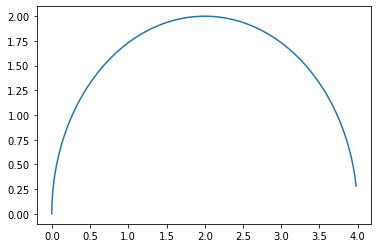

In [6]:
# initial trajectory given dynamics, initial condition, and timescale

traj0 = np.zeros((n, N+1))
traj0[:,0] = s0

xt = s0
for i in range(1, N+1):
    traj0[:, i] = propogate_fwd(xt, u)
    xt = traj0[:, i]
    
plt.plot(traj0[0], traj0[1])



In [7]:
# particle filter function 

def particle_filter(xt, M, timestep):
    '''
    xt : array of M particles 
    M  : number of particles
    timestep : current time
    '''
    
    index_list = [i for i in range(M)]
    
    
    xt = np.copy(xt)            # distribution that descirbes current belief             
    xt_bar = np.zeros((3+1,M))  # update samples of distribution - update = integrator scheme + noise

    
    wt = np.zeros(M) 
    error = np.zeros(M)
    inv_error = np.zeros(M)
    
    # Stage 1A - Move particles to next time step, take ONE measurement, assign weights based on measurement 
    for m in range(M):

        # Step 1: propogate particle with noise 
        noise = noise_distribution([0,0], sigma)
        u_noise = np.add(u, noise)
        particle = propogate_fwd(xt[:, m], u_noise)

        # Step 2: compute weight of particle
        measurement_noise = create_normal_distribution([0,0,0], sigma, 1)
        measurement = traj0[ : , timestep + 1] + measurement_noise
        error = np.linalg.norm(measurement - particle)   
        inv_error[m] = 1/error
        
        # add propagated particle
        xt_bar[0:3, m] = particle.T
    
    # Stage 1B:  add weight to xt_bar   
    sum_inv_error = np.sum(inv_error)
    for m in range(M):
        w = inv_error[m]/sum_inv_error     # particle with smallest error will have highest weight
        xt_bar[3 , m]  = w

    # Stage 2 - resampling (fix particle depression and favor particles with higher weight)
    for m in range(M):

        # Step 1: draw i with probability wt[m] .... weight effects likeliness that you will select the particle 
        weight = xt_bar[3, :]
        i = random.choices(index_list, weight)
        xi = xt_bar[0:3, i]

        # Step 2: add xi to Xt
        xt[:, m] = xi.T
    
    # return distribution at next timestep 
    return xt


    #return xt_bar[0:3,:]    # no resampling
    
    



10
20
30
40
50


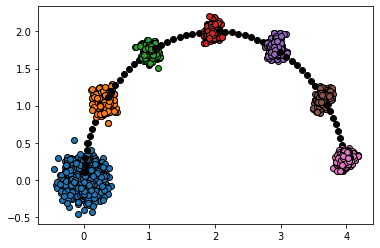

In [8]:
M = 1000                                         # number of particles often 1000
xt = create_normal_distribution(s0, sigma, M)    # normal distribution of variance 0.02 around IC

# plot distribution that describes current belief (normal distribution of variance 0.02 around IC)
plt.scatter(xt[0], xt[1], edgecolors='black')


# generate particles at each timestep and plot the particles every 1 second for a total of 6 seconds
for i in range(N):
    new_xt = particle_filter(xt, M, i)
    xt = new_xt
    
    # average state estimate 
    avg = np.mean(xt, axis= 1)
    plt.scatter(avg[0], avg[1], color = "black")
    
    if i%10 == 0 and i!=0:
        print(i)
        plt.scatter(xt[0], xt[1], edgecolors='black')

    
plt.scatter(xt[0], xt[1], edgecolors='black')